# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here]('http://nlp.stanford.edu:8080/corenlp/') to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [1]:
import os.path
import zipfile
import subprocess
import io

import nltk
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

from nltk.tag import StanfordNERTagger
from nltk.tag import StanfordPOSTagger
from nltk.parse import stanford
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from nltk.draw.tree import TreeView
from nltk.tokenize import sent_tokenize

import graphviz #You also need to install the commandline graphviz
import re

import IPython.display
import tempfile

%matplotlib inline

If you want to use the [Stanford NLP group](http://nlp.stanford.edu/) programs with nltk on your own machine (you do *not* need to do this for this assignment), it will require a little bit of setup. We are basing these instructions on those provided by nltk, [here](https://github.com/nltk/nltk/wiki/Installing-Third-Party-Software#stanford-tagger-ner-tokenizer-and-parser), but with small changes to work with our notebooks. We also note that lower performance versions of many of the techniques demonstrated here are available natively within nltk (see the updated [nltk book](http://www.nltk.org/book/)).

1. Install [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html)
    + Make sure your `JAVAPATH` is setup if you're on windows
2. Download the following zip files from the Stanford NLP group, where DATE is the release date of the files, this will be the value of `stanfordVersion`
    + [`stanford-corenlp-full-2016-10-31.zip`](https://stanfordnlp.github.io/CoreNLP/)
    + [`stanford-postagger-full-DATE.zip`](http://nlp.stanford.edu/software/tagger.html#Download)
    + [`stanford-ner-DATE.zip`](http://nlp.stanford.edu/software/CRF-NER.html#Download)
    + [`stanford-parser-full-DATE.zip`](http://nlp.stanford.edu/software/lex-parser.html#Download)
3. Unzip the files and place the resulting directories in the same location, this will become `stanfordDir`
4. Lookup the version number used by the parser `stanford-parser-VERSION-models.jar` and set to to be `parserVersion`

In [2]:
#This is the date at the end of each of the zip files, e.g.
#the date in stanford-ner-2016-10-31.zip
stanfordVersion = '2016-10-31'

#This is the version numbers of the parser models, these
#are files in `stanford-parser-full-2016-10-31.zip`, e.g.
#stanford-parser-3.7.0-models.jar
parserVersion = '3.7.0'

#This is where the zip files were unzipped.Make sure to
#unzip into directories named after the zip files
#Don't just put all the files in `stanford-NLP`
stanfordDir = '/mnt/efs/resources/shared/stanford-NLP'

#Parser model, there are a few for english and a couple of other languages as well
modelName = 'englishPCFG.ser.gz'

We now will initialize all the tools

Setting up [NER tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordNERTagger)

In [3]:
nerClassifierPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'classifiers/english.all.3class.distsim.crf.ser.gz')

nerJarPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'stanford-ner.jar')

nerTagger = StanfordNERTagger(nerClassifierPath, nerJarPath)

Setting up [POS Tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordPOSTagger)

In [4]:
postClassifierPath = os.path.join(stanfordDir, 'stanford-postagger-full-{}'.format(stanfordVersion), 'models/english-bidirectional-distsim.tagger')

postJarPath = os.path.join(stanfordDir,'stanford-postagger-full-{}'.format(stanfordVersion), 'stanford-postagger.jar')

postTagger = StanfordPOSTagger(postClassifierPath, postJarPath)

Setting up [Parser](http://www.nltk.org/api/nltk.parse.html?highlight=stanfordparser#module-nltk.parse.stanford)

In [5]:
parserJarPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser.jar')

parserModelsPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser-{}-models.jar'.format(parserVersion))

modelPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), modelName)

#The model files are stored in the jar, we need to extract them for nltk to use
if not os.path.isfile(modelPath):
    with zipfile.ZipFile(parserModelsPath) as zf:
        with open(modelPath, 'wb') as f:
            f.write(zf.read('edu/stanford/nlp/models/lexparser/{}'.format(modelName)))

parser = stanford.StanfordParser(parserJarPath, parserModelsPath, modelPath)

depParser = stanford.StanfordDependencyParser(parserJarPath, parserModelsPath)

Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we will be defining our own function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame.

In [6]:
#Watch out, this will very rarely raise an error since it trusts stanford-corenlp 
def openIE(target):
    if isinstance(target, list):
        target = '\n'.join(target)
    #setup the java targets
    coreDir = '{}/stanford-corenlp-full-{}'.format(stanfordDir, stanfordVersion)
    cp = '{0}/stanford-corenlp-{1}.jar:{0}/stanford-corenlp-{1}-models.jar:CoreNLP-to-HTML.xsl:slf4j-api.jar:slf4j-simple.jar'.format(coreDir, parserVersion)
    with tempfile.NamedTemporaryFile(mode = 'w', delete = False) as f:
        #Core nlp requires a files, so we will make a temp one to pass to it
        #This file should be deleted by the OS soon after it has been used
        f.write(target)
        f.seek(0)
        print("Starting OpenIE run")
        #If you know what these options do then you should mess with them on your own machine and not the shared server
        sp = subprocess.run(['java', '-mx2g', '-cp', cp, 'edu.stanford.nlp.naturalli.OpenIE', '-threads', '1', f.name], stdout = subprocess.PIPE, stderr = subprocess.PIPE)
        #Live stderr is non-trivial so this is the best we can do
        print(sp.stderr.decode('utf-8'))
        retSting = sp.stdout.decode('utf-8')
    #Making the DataFrame, again having to pass a fake file, yay POSIX I guess
    with io.StringIO(retSting) as f:
        df = pandas.read_csv(f, delimiter = '\t', names =['certainty', 'subject', 'verb', 'object'])
    return df

Now lets illustrate these tools on some *very* short examples:

In [7]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [8]:
pos_sents = postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [9]:
redditDF = pandas.read_csv('data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization is sometimes performed where we translate synonyms into the same focal word).

In [10]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, ,, Help, Desk, got, a, call, fro..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time, !], [I, ..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[[, Original, Post, ], (, https, :, //www.red..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [11]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: postTagger.tag_sents(x))

In [12]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [13]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 (')', 14),
 ('time', 14),
 ('computer', 12),
 ('lot', 12),
 ('email', 11),
 ('life', 11),
 ('**Genius**', 10),
 ('day', 9),
 ('**Me**', 9),
 ('system', 9),
 ('message', 9),
 ('laptop', 8),
 ('today', 8),
 ('story', 8),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('problem', 7)]

What about the number of top verbs (`VB`)?

In [14]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('tell', 6),
 ('look', 6),
 ('help', 6),
 ('send', 6),
 ('go', 5),
 ('open', 4),
 ('receive', 4),
 ('take', 4),
 ('want', 4),
 ('use', 4),
 ('see', 4),
 ('call', 4)]

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Visualize the distribution for at least three different parts of speech. What do these distributions suggest about your corpus?

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [15]:
classified_sents = nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [16]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: nerTagger.tag_sents(x))

KeyboardInterrupt: 

In [ ]:
redditTopScores['classified_sents']

Find the most common entities (which are, of course, boring):

In [ ]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

Or those occurring only twice:

In [ ]:
[x[0] for x in sortedEntities if x[1] == 2]

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [ ]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

What about the Organizations?

In [ ]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

These, of course, have much smaller counts.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of the corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for that classification.

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. While the parser is a dependency parser, this initial program outputs a simple, self-explanatory phrase-structure representation.

In [110]:
parses = list(parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in though is the realtionship between different types of speech

In [126]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [127]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice

We can use the function on any number of targets

In [128]:
treeRelation(fourthSentParseTree, 'NNP', 'Florida')

[[('NNP', 'Florida')], [('NNP', 'Florida')]]

Or if we want to to look at the whole tree

In [129]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [130]:
list(parses[1])[0].pretty_print()

IndexError: list index out of range

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [86]:
depParses = list(depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x7fee6cf4fd90>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'w

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another.

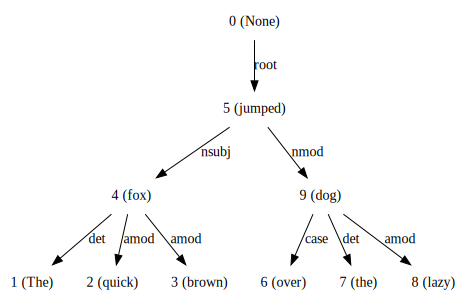

In [87]:
secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
secondSentGraph

Or another sentence 

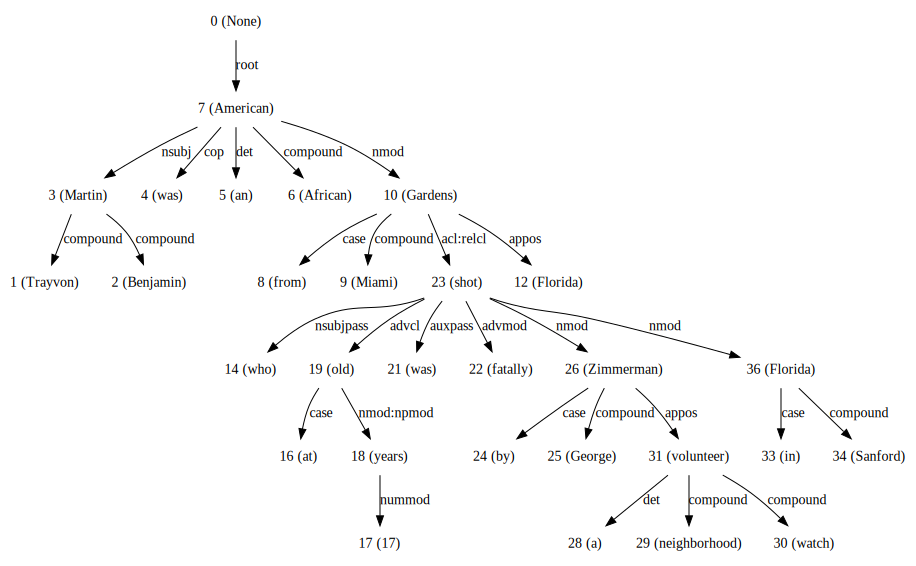

In [88]:
graphviz.Source(list(depParses[3])[0].to_dot())

We can traverse this tree by indexing:

In [94]:
HELP...how can we iterate through the parse tree. I would like to ask, 

TypeError: 'list_iterator' object is not subscriptable

We can also do a dependency parse on the reddit sentences:

In [58]:
topPostDepParse = list(depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [24]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

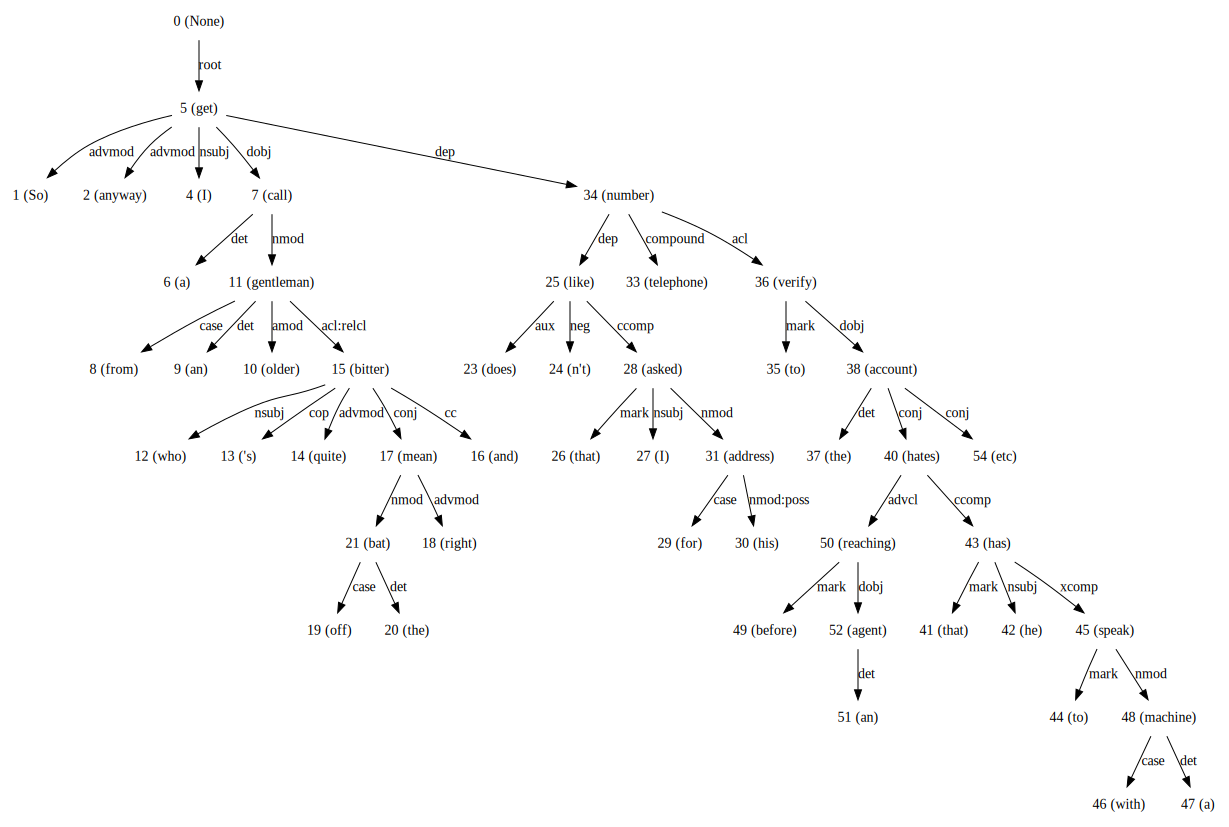

In [25]:
graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these actors are perceive to play in the social world inscribed by your texts?

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [53]:
ieDF = openIE(text)

Starting OpenIE run
Adding annotator tokenize
Adding annotator ssplit
Adding annotator pos
Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [3.4 sec].
Adding annotator lemma
Adding annotator depparse
Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
PreComputed 99996, Elapsed Time: 48.726 (s)
Initializing dependency parser ... done [52.8 sec].
Adding annotator natlog
Adding annotator openie
Loading clause splitter from edu/stanford/nlp/models/naturalli/clauseSearcherModel.ser.gz ... done [0.0326 seconds]
Processing file: /tmp/tmpasi3kz7a
All files have been queued; awaiting termination...
DONE processing files. 0 exceptions encountered.



`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [54]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Your thoughts*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?)

And we can also look for subject, object, target triples in one of the reddit stories.

In [89]:
ieDF = openIE(redditTopScores['text'][0])

Starting OpenIE run
Adding annotator tokenize
Adding annotator ssplit
Adding annotator pos
Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [2.5 sec].
Adding annotator lemma
Adding annotator depparse
Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
PreComputed 99996, Elapsed Time: 43.835 (s)
Initializing dependency parser ... done [47.7 sec].
Adding annotator natlog
Adding annotator openie
Loading clause splitter from edu/stanford/nlp/models/naturalli/clauseSearcherModel.ser.gz ... done [2.0109 seconds]
Processing file: /tmp/tmpy6dpih7k
All files have been queued; awaiting termination...
DONE processing files. 0 exceptions encountered.



In [34]:
ieDF

,certainty,subject,verb,object
0,1.000000,we,'ll get,calls
1,1.000000,we,Quite often 'll get,calls
2,1.000000,we,often 'll get,calls
3,0.831036,we,coax,direct to TV
4,0.774359,straight analog cable,coax,direct from wall
5,0.774359,analog cable,coax,direct from wall to TV
6,0.774359,straight analog cable,coax,direct to TV
7,1.000000,we,would supply analog cable to,homes
8,0.831036,we,coax,direct from wall
9,0.774359,analog cable,coax,direct from wall


That's almost 200 triples in only:

In [35]:
len(redditTopScores['sentences'][0])

37

sentences and

In [36]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [37]:
ieDF['subject'].value_counts()

I                        48
it                       42
he                       19
He                       18
we                       11
man                       8
old man                   8
letter                    4
our booking calendar      4
call                      4
analog cable              4
straight analog cable     4
my supervisor             3
you                       2
they                      2
TV                        2
his TV set                2
people                    1
handling                  1
me                        1
our equipment             1
our digital equipment     1
repeat offenders          1
Name: subject, dtype: int64

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [38]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

could come                        8
brought                           5
even brought                      5
was                               4
had                               4
speak for                         3
So anyway get                     1
felt                              1
still think about                 1
instantly felt                    1
had cable within                  1
get to                            1
complaint in                      1
anyway get                        1
think about                       1
get                               1
do                                1
think occasionally about          1
eventually had                    1
took                              1
have                              1
still think occasionally about    1
speak with                        1
ask                               1
've dealt with                    1
Name: verb, dtype: int64

and the following objects

In [39]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Mr. Smith                                             4
him                                                   3
call                                                  3
simplified remote                                     2
get                                                   2
this                                                  2
willing                                               2
simplified remote for his set top box                 2
bad                                                   2
remote                                                2
remote for his set top box                            2
cable                                                 1
speak with her for bit about account for Mr. Smith    1
bit about account for Mr. Smith                       1
book                                                  1
bit about account                                     1
how useless                                           1
speak with her for bit                          

## <span style="color:red">*Your Turn*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa? Describe how you would select among these statements to create a database of high-value statements for your project and do it.

# Testing POS

We can check the POS tagger by running it on an already tagged corpus and counting the number of errors

In [14]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [15]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [38]:
stanfordTags = postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [40]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The difference rate is {:.3f}%".format(NumDiffs /total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is very good